# Introduction

So much about wine making remains elusive. Taste is very subjective, making it extremely challenging to predict exactly how consumers will react to a certain bottle of wine. Wine experts have created extensive forms of common language to talk about wine — astringency, empyreumatic, minerality, etc. — most of which, to the average consumers, seem inaccessible and full of jargon. But still, in reality, consumers deeply appreciate being helped by professionals. They often give free rein to wine advisors, sommeliers, or any other wine professionals who master the language and knowledge of wine. Furthermore with an increasing number of available wine references, it's even harder for consumers to take into account all possibilities. To face this human issue, a wine expert (e.g., wine merchant or a sommelier) often curates and recommends their top wines of the moment.

Because deep learning tries to imitate the workings of the human brain in processing information (and automatically generates patterns for decision making and other complicated tasks), it can be a tremendous tool to help us understand and mimic the decision-making process of the experts in this field. This notebook contains a step-by-step approach to create a deep learning model using Tensorflow to predict the quality of wine (i.e., how well it's received and scored by wine experts after a blind taste test) based on its physicochemical measurements. We will also extract model insights using SHAP values.

## Our Approach

Deep learning models are capable enough to focus on the accurate features themselves by requiring a little guidance from the programmer and are mostly used in solving out the problem of dimensionality. This also means that they excel in cases where humans don't necessarily know what feature representations are best for a given task.

Feature engineering and feature extraction are key (and time consuming) parts of most machine learning workflows. They are about transforming training data and augmenting it with additional features to make machine learning algorithms more effective. Deep learning allows us to take a slightly different approach. The feature engineering approach was the dominant approach in machine learning until deep learning techniques started demonstrating recognition performance better than the carefully crafted feature detectors. Deep learning shifts the burden of feature design to the underlying learning system. With deep learning, for example, it is possible start with raw data as features will be automatically created by the neural network when it learns.

Note that this does not mean that data preprocessing, feature extraction, and feature engineering are totally irrelevant when one uses deep learning. In reality many deep learning neural networks contain hard coded data processing, feature extraction, and feature engineering. They may require less of these as manual operations than other machine learning algorithms, but they may require (and could massively benefit from) some still. While deep learning has simplified feature engineering, the architectures of the machine learning models themselves have become increasingly more complex. Most of the time, these model architectures are as specific to a given task as feature engineering used to be. In short, with deep learning, architecture engineering is the new feature engineering.

In [14]:
# TensorFlow
import tensorflow as tf
print("Tensorflow version " + tf.__version__)


# Model
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks


# Plotting
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Matplotlib defaults
plt.style.use('seaborn-darkgrid')
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)


# Data Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline


from sklearn.metrics import mean_absolute_error
import numpy as np
import shap

import warnings
warnings.filterwarnings('ignore')




Tensorflow version 2.6.0


In [4]:
# Set Global Random Seed (to get stable results)

from numpy.random import seed
seed(42)

tf.random.set_seed(42)

## Dataset

The data set we're going to work with contains records related to red and white variants of the Portuguese Vinho Verde wine. It contains information from 1599 red wine samples and 4898 white wine samples. Input variables in the data set consist of the type of wine (either red or white wine) and 11 additional metrics from objective tests (e.g. acidity levels, PH values, ABV, etc.), while the target/output variable is a numerical score based on sensory data—median of at least 3 evaluations (blind test) made by wine experts. Each expert graded the wine quality between 0 (very bad) and 10 (very excellent). Due to privacy and logistic issues, there is no data about grape types, wine brand, and wine selling price.

For more details, visit the [dataset page.](https://www.kaggle.com/ruthgn/wine-quality-data-set-red-white-wine)

### Data Preprocessing

In [8]:
def split_data(ds):
    ds_train, val_test_ds = train_test_split(ds, test_size=0.2, random_state=1)
    ds_valid, ds_test = train_test_split(val_test_ds, test_size=0.5, random_state=1)
    return ds_train, ds_valid, ds_test

In [9]:
def load_data(ds_train, ds_test):
    ds_train = pd.DataFrame(preprocessor.fit_transform(ds_train))
    ds_train.columns = features_num + ["type_red", "type_white"]
    
    ds_test = pd.DataFrame(preprocessor.transform(ds_test))
    ds_test.columns = features_num + ["type_red", "type_white"]
    
    X_train = ds_train.drop('quality', axis=1)
    y_train = ds_train['quality']
    
    X_test = ds_test.drop('quality', axis=1)
    y_test = ds_test['quality']
    
    return X_train, X_test, y_train, y_test

### Encoding (Categorical Data)

In [15]:
transformer_cat = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="NA"), # Fortunately, no missing values
    OneHotEncoder(handle_unknown='ignore'))

### Scaling (Numeric Data)
For neural networks, it's generally a good idea to put all of your data on a common scale, perhaps with something like scikit-learn's `StandardScaler` or `MinMaxScaler`. The reason is that the weights in a neural network are calculated in proportion to how large an activation the data produces. Features that tend to produce activations of very different sizes can make for unstable training behavior.

In [16]:
transformer_num = make_pipeline(
    #SimpleImputer(strategy="constant"), # Fortunately, no missing values
    #StandardScaler(),
    MinMaxScaler(),
)

In [17]:
# Read data
ds = pd.read_csv('wine-quality-white-and-red.csv')

# Create data splits
ds_train, ds_valid, ds_test = split_data(ds)

In [20]:
features_num = [
    'fixed acidity', 'volatile acidity', 'citric acid',
    'residual sugar', 'chlorides', 'free sulfur dioxide',
    'total sulfur dioxide', 'density', 'pH', 'sulphates', 
    'alcohol', 'quality']

features_cat = ["type"]


preprocessor = make_column_transformer(
    (transformer_num, features_num),
    (transformer_cat, features_cat),
)

In [21]:
# Execute load_data() for training
X_train, X_valid, y_train, y_valid = load_data(ds_train, ds_valid)

In [23]:
# Original Data
ds_orig = pd.read_csv('wine-quality-white-and-red.csv')
ds_orig.head()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,white,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [24]:
# Processed Features (training set - in DataFrame form)
pd.DataFrame(X_train).head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,type_red,type_white
0,0.196581,0.080000,0.203252,0.220859,0.076412,0.024306,0.262673,0.203586,0.364341,0.174157,0.258065,0.0,1.0
1,0.213675,0.120000,0.349593,0.184049,0.039867,0.218750,0.516129,0.198381,0.279070,0.089888,0.145161,0.0,1.0
2,0.239316,0.020000,0.211382,0.217791,0.073090,0.149306,0.205069,0.186042,0.372093,0.073034,0.290323,0.0,1.0
3,0.376068,0.146667,0.292683,0.144172,0.054817,0.111111,0.375576,0.213804,0.395349,0.162921,0.209677,0.0,1.0
4,0.273504,0.240000,0.300813,0.032209,0.053156,0.118056,0.281106,0.048005,0.271318,0.117978,0.887097,0.0,1.0


## Define Model

Now that the data is ready, we want to define our neural network using the Sequential method. Deciding the architecture of your model should be an iterative process.

Let's start with the simplest network -- a Keras implementation of a linear model. This model has low capacity. A model's capacity refers to the size and complexity of the patterns it is able to learn. For neural networks, this will largely be determined by how many neurons it has and how they are connected together. If it appears that your network is underfitting the data, you should try increasing its capacity. You can increase the capacity of a network either by making it wider (more units to existing layers) or by making it deeper (adding more layers). Wider networks have an easier time learning more linear relationships, while deeper networks prefer more nonlinear ones. Which is better just depends on the dataset.

We want to start simple and eventually use the validation loss as a guide for our experimentation. We've told Keras to feed the optimizer 256 rows of the training data at a time (the batch_size) and to do that 300 times all the way through the dataset (the epochs). With batch size (and learning rate, which we'll determine later), you have some control over:

- How long it takes to train a model
- How noisy the learning curves are
- How small the loss becomes
We've collected these hyperparameters in the next cell to make experimentation easier:

In [25]:
# Training Configuration
EPOCHS = 300
BATCH_SIZE = 2 ** 8 #256

The number of inputs a network has should be equal to the number of input feature columns in the data matrix. In this analysis, be sure not to include the target ('quality') here -- only the input features.

In [26]:
input_shape=[X_train.shape[1]]

Why is input_shape a Python list? The data we'll use in this course will be tabular data, like in a Pandas dataframe. We'll have one input for each feature in the dataset. The features are arranged by column, so we'll always have input_shape=[num_columns]. The reason Keras uses a list here is to permit use of more complex datasets. Image data, for instance, might need three dimensions: [height, width, channels].

Minimum Validation Loss: 0.0153
Minimum Validation MAE (mean absolute error): 0.0975


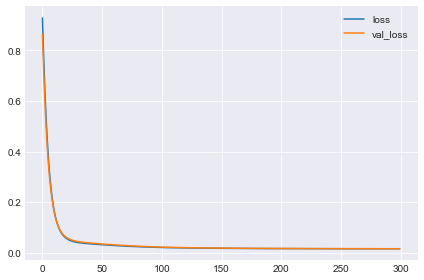

In [27]:
# Define linear model
model = keras.Sequential([
    layers.Dense(1, input_shape=input_shape),
])

# Compile in the optimizer and loss function
model.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae']
)

# Fit model (and save training history)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose=0, # suppress output since we'll plot the curves
)

# Convert the training history to a dataframe
history_frame = pd.DataFrame(history.history)

# Plot training history
history_frame.loc[0:, ['loss', 'val_loss']].plot()

print("Minimum Validation Loss: {:0.4f}".format(history_frame['val_loss'].min()));
print("Minimum Validation MAE (mean absolute error): {:0.4f}".format(history_frame['val_mae'].min()));

Minimum Validation Loss: 0.0139
Minimum Validation MAE (mean absolute error): 0.0923


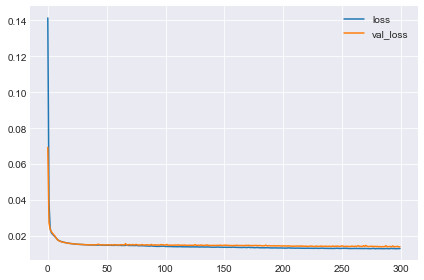

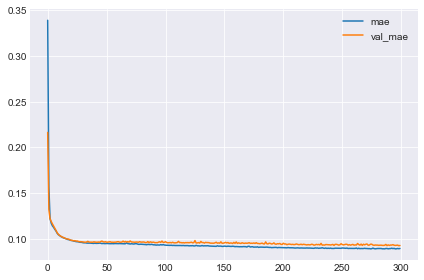

In [28]:
# Define model with two representation layers
model = keras.Sequential([
    layers.Dense(2 ** 4, activation='relu', input_shape=input_shape),
    layers.Dense(2 ** 4, activation='relu'),
    layers.Dense(1),
])

# Compile in the optimizer and loss function
model.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae']
)

# Fit model (and save training history)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose=0, # suppress output since we'll plot the curves
)

# Convert the training history to a dataframe
history_frame = pd.DataFrame(history.history)

# Plot training history
history_frame.loc[0:, ['loss', 'val_loss']].plot()
history_frame.loc[0:, ['mae', 'val_mae']].plot()

print("Minimum Validation Loss: {:0.4f}".format(history_frame['val_loss'].min()));
print("Minimum Validation MAE (mean absolute error): {:0.4f}".format(history_frame['val_mae'].min()));

**In the previous model, we used two representation layers before the final layer. We can try experimenting with using one or three representation layers, for example, and see how doing so impacts validation metrics. We can also change the number of units/neurons in each layer and see how it affects the validation loss and metric**

Minimum Validation Loss: 0.0140
Minimum Validation MAE (mean absolute error): 0.0920


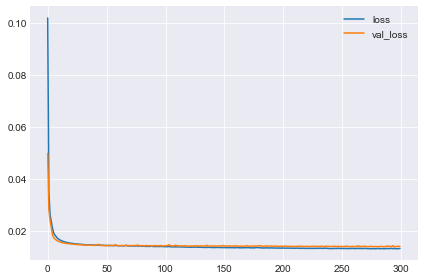

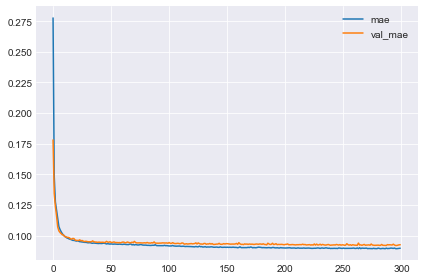

In [29]:
# Define model with one representation layer
model = keras.Sequential([
    layers.Dense(2 ** 4, activation='relu', input_shape=input_shape),
    layers.Dense(1),
])

# Compile in the optimizer and loss function
model.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae']
)

# Fit model (and save training history)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose=0, # suppress output since we'll plot the curves
)

# Convert the training history to a dataframe
history_frame = pd.DataFrame(history.history)

# Plot training history
history_frame.loc[0:, ['loss', 'val_loss']].plot()
history_frame.loc[0:, ['mae', 'val_mae']].plot()

print("Minimum Validation Loss: {:0.4f}".format(history_frame['val_loss'].min()));
print("Minimum Validation MAE (mean absolute error): {:0.4f}".format(history_frame['val_mae'].min()));

Minimum Validation Loss: 0.0139
Minimum Validation MAE (mean absolute error): 0.0901


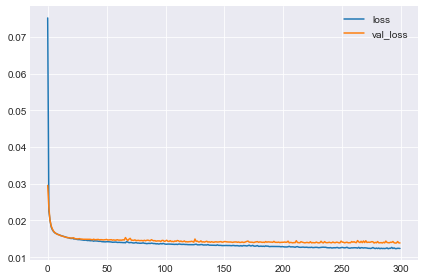

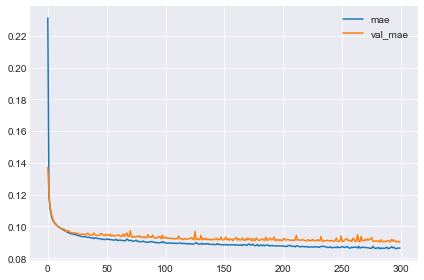

In [30]:
# Define model with three representation layers
model = keras.Sequential([
    layers.Dense(2 ** 4, activation='relu', input_shape=input_shape),
    layers.Dense(2 ** 4, activation='relu'),
    layers.Dense(2 ** 4, activation='relu'),
    layers.Dense(1),
])

# Compile in the optimizer and loss function
model.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae']
)

# Fit model (and save training history)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose=0, # suppress output since we'll plot the curves
)

# Convert the training history to a dataframe
history_frame = pd.DataFrame(history.history)

# Plot training history
history_frame.loc[0:, ['loss', 'val_loss']].plot()
history_frame.loc[0:, ['mae', 'val_mae']].plot()

print("Minimum Validation Loss: {:0.4f}".format(history_frame['val_loss'].min()));
print("Minimum Validation MAE (mean absolute error): {:0.4f}".format(history_frame['val_mae'].min()));

Minimum Validation Loss: 0.0137
Minimum Validation MAE (mean absolute error): 0.0896


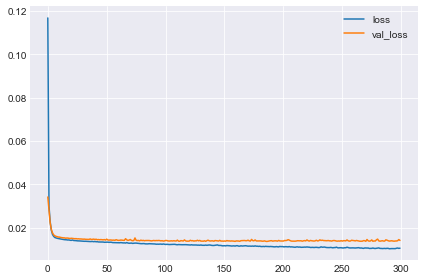

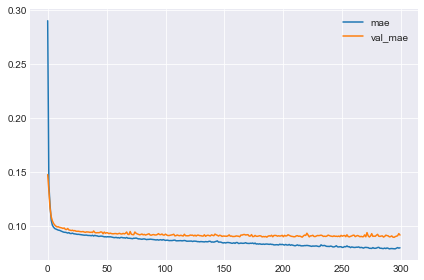

In [31]:
# Define model with three representation layers and 32 units per lays
model = keras.Sequential([
    layers.Dense(2 ** 5, activation='relu', input_shape=input_shape),
    layers.Dense(2 ** 5, activation='relu'),
    layers.Dense(2 ** 5, activation='relu'),
    layers.Dense(1),
])

# Compile in the optimizer and loss function
model.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae']
)

# Fit model (and save training history)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose=0, # suppress output since we'll plot the curves
)

# Convert the training history to a dataframe
history_frame = pd.DataFrame(history.history)

# Plot training history
history_frame.loc[0:, ['loss', 'val_loss']].plot()
history_frame.loc[0:, ['mae', 'val_mae']].plot()

print("Minimum Validation Loss: {:0.4f}".format(history_frame['val_loss'].min()));
print("Minimum Validation MAE (mean absolute error): {:0.4f}".format(history_frame['val_mae'].min()));

Minimum Validation Loss: 0.0130
Minimum Validation MAE (mean absolute error): 0.0874


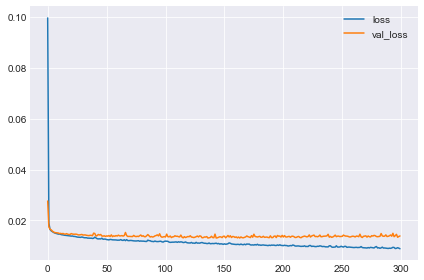

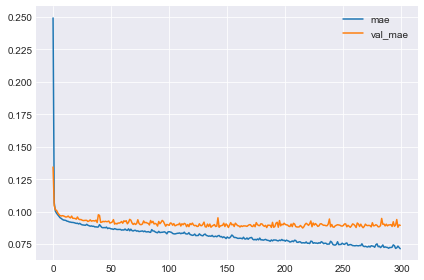

In [32]:
# Define Baseline Model with three representation layers and 64 units per layer
model = keras.Sequential([
    layers.Dense(2 ** 6, activation='relu', input_shape=input_shape),
    layers.Dense(2 ** 6, activation='relu'),
    layers.Dense(2 ** 6, activation='relu'),
    layers.Dense(1),
])

# Compile in the optimizer and loss function
model.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae']
)

# Fit model (and save training history)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose=0, # suppress output since we'll plot the curves
)

# Convert the training history to a dataframe
history_frame = pd.DataFrame(history.history)

# Plot training history
history_frame.loc[0:, ['loss', 'val_loss']].plot()
history_frame.loc[0:, ['mae', 'val_mae']].plot()

print("Minimum Validation Loss: {:0.4f}".format(history_frame['val_loss'].min()));
print("Minimum Validation MAE (mean absolute error): {:0.4f}".format(history_frame['val_mae'].min()));

**The gap between these curves is quite small and the validation loss never increases, so it's more likely that the network is underfitting than overfitting. Now we know it's worth experimenting with even more capacity to see if that's the case.**

### Optimize model capacity

Minimum Validation Loss: 0.0127
Minimum Validation MAE (mean absolute error): 0.0692


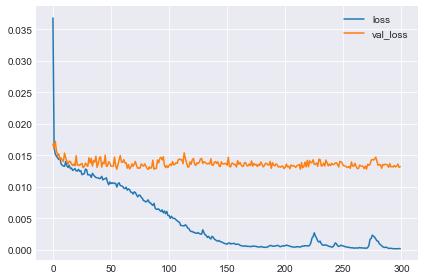

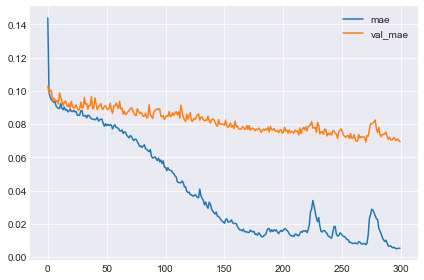

In [33]:
# Define new model (use previous baseline model as comparison)
model = keras.Sequential([
    layers.Dense(2 ** 10, activation='relu', input_shape=input_shape),
    layers.Dense(2 ** 10, activation='relu'),
    layers.Dense(2 ** 10, activation='relu'),
    layers.Dense(2 ** 10, activation='relu'),
    layers.Dense(2 ** 10, activation='relu'),
    layers.Dense(1),
])

# Compile in the optimizer and loss function
model.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae']
)

# Fit model (and save training history)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose=0, # suppress output since we'll plot the curves
)

# Convert the training history to a dataframe
history_frame = pd.DataFrame(history.history)

# Plot training history
history_frame.loc[0:, ['loss', 'val_loss']].plot()
history_frame.loc[0:, ['mae', 'val_mae']].plot()

print("Minimum Validation Loss: {:0.4f}".format(history_frame['val_loss'].min()));
print("Minimum Validation MAE (mean absolute error): {:0.4f}".format(history_frame['val_mae'].min()));

**Now the training loss continues to decrease but the gap between validation loss and training loss is starting grow bigger each time we increase the capacity of our model. This can indicate that the network may begin to overfit if we keep increasing the number of epoch to keep decreasing our loss. Overfitting is a real possibility since we are using a fairly large network -- perhaps we should create a callback to halt the training once the validation loss shows signs of increasing.**

### Callbacks definition

In [34]:
# (Updated) Training Configuration
EPOCHS = 3000

In Keras, a callback is just a function you want run every so often while the network trains. We can simply stop the training whenever it seems the validation loss isn't decreasing anymore by using early stopping through a callback. When using early stopping, we can choose a large number of epochs -- more than we'll actually need.

Additionally, we've also defined a learning rate schedule. It's been found that gradually decreasing the learning rate over the course of training can improve performance (the weights "settle in" to a minimum). This schedule will multiply the learning rate by 0.2 if the validation loss didn't decrease after an epoch. (Note: A smaller learning rate means the network needs to see more minibatches before its weights converge to their best values.)

In [36]:
#Defining callbacks
early_stopping = callbacks.EarlyStopping(
    patience=50, # how many epochs to wait before stopping
    min_delta=0.001, # minimium amount of change to count as an improvement
    restore_best_weights=True
)

lr_schedule = callbacks.ReduceLROnPlateau(
    patience=0,
    factor=0.2,
    min_lr=0.001
)

Minimum Validation Loss: 0.0116
Minimum Validation MAE (mean absolute error): 0.0626


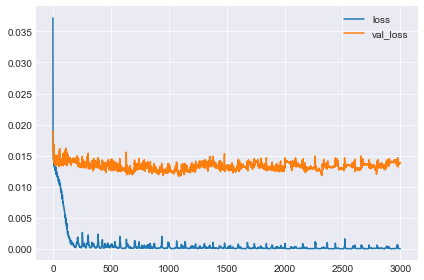

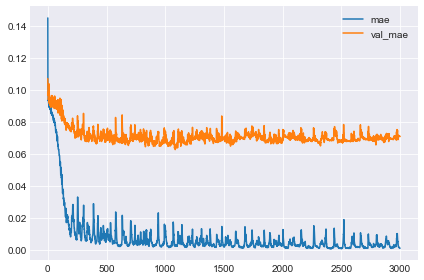

In [37]:
# Define model
# Add callbacks
model = keras.Sequential([
    layers.Dense(2 ** 10, activation='relu', input_shape=input_shape),
    layers.Dense(2 ** 10, activation='relu'),
    layers.Dense(2 ** 10, activation='relu'),
    layers.Dense(2 ** 10, activation='relu'),
    layers.Dense(2 ** 10, activation='relu'),
    layers.Dense(1),
])

# Compile in the optimizer and loss function
model.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae']
)

# Fit model (and save training history)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose=0, # suppress output since we'll plot the curves
)

# Convert the training history to a dataframe
history_frame = pd.DataFrame(history.history)

# Plot training history
history_frame.loc[0:, ['loss', 'val_loss']].plot()
history_frame.loc[0:, ['mae', 'val_mae']].plot()

print("Minimum Validation Loss: {:0.4f}".format(history_frame['val_loss'].min()));
print("Minimum Validation MAE (mean absolute error): {:0.4f}".format(history_frame['val_mae'].min()));

### Add Dropout Layers
A dropout layer can help correct overfitting. By randomly dropping out some fraction of a layer's input units every step of training, we're making it much harder for the network to learn spurious patterns in the training data (which can cause overfitting), and forces it to search for broad, general patterns instead, whose weight patterns tend to be more robust.

Now we'll increase the capacity even more (by adding another dense layer), but also add dropout layers to control overfitting. Specifically, we're adding a 20% dropout layer for after each dense layer (excluding output layer).

Minimum Validation Loss: 0.0133
Minimum Validation MAE (mean absolute error): 0.0886


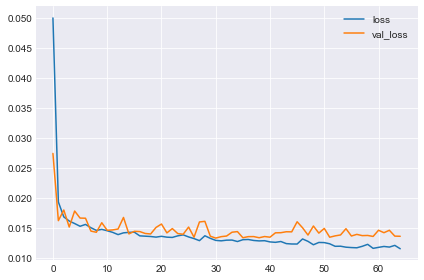

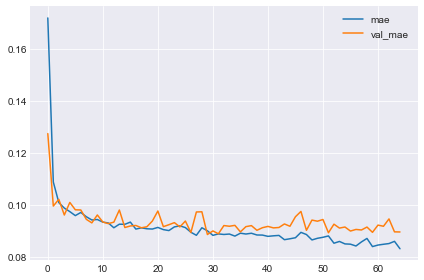

In [38]:
# Define model
# Add dropout layers
model = keras.Sequential([
    layers.Dense(2 ** 10, activation='relu', input_shape=input_shape),
    layers.Dropout(0.2),
    layers.Dense(2 ** 10, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(2 ** 10, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(2 ** 10, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(2 ** 10, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1),
])

# Compile in the optimizer and loss function
model.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae']
)

# Fit model (and save training history)
# (Add callbacks)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping, lr_schedule],
    verbose=0, # suppress output since we'll plot the curves
)

# Convert the training history to a dataframe
history_frame = pd.DataFrame(history.history)

# Plot training history
history_frame.loc[0:, ['loss', 'val_loss']].plot()
history_frame.loc[0:, ['mae', 'val_mae']].plot()

print("Minimum Validation Loss: {:0.4f}".format(history_frame['val_loss'].min()));
print("Minimum Validation MAE (mean absolute error): {:0.4f}".format(history_frame['val_mae'].min()));

### Add Batch Normalization Layers
As explained earlier in the notebook, it's generally a good idea to put all of your data on a common scale with dealing with neural networks. Now, if it's good to normalize the data before it goes into the network, normalizing inside the network would be even better! A batch normalization layer performs a kind of coordinated rescaling of its inputs -- it looks at each batch as it comes in, first normalizing the batch with its own mean and standard deviation, and then also putting the data on a new scale with two trainable rescaling parameters. Batch normalization can be used at almost any point in a network.

Batch normalization helps speed up optimization (though it can sometimes also help prediction performance) and models with batchnorm tend to need fewer epochs to complete training.

In [39]:
# Define model
# Add batch normalization layers
model = keras.Sequential([
    layers.Dense(2 ** 10, activation='relu', input_shape=input_shape),
    layers.Dropout(0.2),
    layers.BatchNormalization(),
    layers.Dense(2 ** 10, activation='relu'),
    layers.Dropout(0.2),
    layers.BatchNormalization(),
    layers.Dense(2 ** 10, activation='relu'),
    layers.Dropout(0.2),
    layers.BatchNormalization(),
    layers.Dense(2 ** 10, activation='relu'),
    layers.Dropout(0.2),
    layers.BatchNormalization(),
    layers.Dense(2 ** 10, activation='relu'),
    layers.Dropout(0.2),
    layers.BatchNormalization(),
    layers.Dense(1),
])

# Compile in the optimizer and loss function
model.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae']
)

# Fit model (and save training history)
# (Add callbacks)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping, lr_schedule],
    verbose=1, # suppress output since we'll plot the curves
)

# Convert the training history to a dataframe
history_frame = pd.DataFrame(history.history)

# Plot training history
history_frame.loc[0:, ['loss', 'val_loss']].plot()
history_frame.loc[0:, ['mae', 'val_mae']].plot()

print("Minimum Validation Loss: {:0.4f}".format(history_frame['val_loss'].min()));
print("Minimum Validation MAE (mean absolute error): {:0.4f}".format(history_frame['val_mae'].min()));

Epoch 1/3000
21/21 [==============================] - 20s 164ms/step - loss: 3.3146 - mae: 1.3147 - val_loss: 0.0259 - val_mae: 0.1259
Epoch 2/3000
21/21 [==============================] - 3s 151ms/step - loss: 0.9292 - mae: 0.7561 - val_loss: 0.0385 - val_mae: 0.1486
Epoch 3/3000
21/21 [==============================] - ETA: 0s - loss: 0.5797 - mae: 0.59

limit_output extension: Maximum message size of 10000 exceeded with 10055 characters

## Model evaluation and prediction

In [40]:
# Combine training set and validation set to train final model
ds_train = ds_train.append(ds_valid)

# Execute load_data() for prediction
X_train, X_test, y_train, y_test = load_data(ds_train, ds_test)

**We're going to re-write our final model using Keras's Functional API (better flexibility than the Sequential method we've used previously for future modifications) and re-train it using the complete training data (X_train and X_valid combined) before making predictions on the test set.**

In [41]:
# Training configuration
BATCH_SIZE = 2 ** 8

# Model Configuration
UNITS = 2 ** 10
ACTIVATION = 'relu'
DROPOUT = 0.2

In [42]:
# Build final model from scratch

def dense_block(units, activation, dropout_rate, l1=None, l2=None):
    def make(inputs):
        x = layers.Dense(units)(inputs)
        x = layers.Activation(activation)(x)
        x = layers.Dropout(dropout_rate)(x)
        x = layers.BatchNormalization()(x)
        return x
    return make

   
# Model 
inputs = keras.Input(shape=(13,))
x = dense_block(UNITS, ACTIVATION, DROPOUT)(inputs)
x = dense_block(UNITS, ACTIVATION, DROPOUT)(x)
x = dense_block(UNITS, ACTIVATION, DROPOUT)(x)
x = dense_block(UNITS, ACTIVATION, DROPOUT)(x)
x = dense_block(UNITS, ACTIVATION, DROPOUT)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs=inputs, outputs=outputs)


# Compile in the optimizer and loss function
model.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae']
)


# Fit model (and save training history)
history = model.fit(
    X_train, y_train,
    batch_size=BATCH_SIZE,
    epochs=75,
    verbose=0,
)


# Making predictions from test set
predictions = model.predict(X_test)


# Evaluate
model_score = mean_absolute_error(y_test, predictions)
print("Final model score (MAE):", model_score)

Final model score (MAE): 0.09098226091800592


## Model Interpretation

 ability to understand what is happening in a model depends on the interpretability of the particular model. There is often a tradeoff between a model’s accuracy and its interpretability. Simple linear models can be straightforward and easy understand, as they directly expose the impacts of variables and coefficients. Non-linear models, including those derived by neural networks like the one the we've built, can be much more difficult to interpret. This is where SHAP (or SHapley Additive exPlanations) come to our rescue. SHAP is a Python library created by Scott Lundberg that can explain the output of many machine learning frameworks, including those that are more challenging to interpret because of their complexity and non-linearity, such as neural networks and gradient-boosted trees.

[This blog post](https://towardsdatascience.com/one-feature-attribution-method-to-supposedly-rule-them-all-shapley-values-f3e04534983d) gives you a good theoretical explanation for SHAP and is a joy to read.

In the beginning of this notebook, we discussed how neural networks can automatically generate patterns for information processing and decision making. The model we've built tries to mimick the decision-making patterns of wine experts in assessing the quality of wine. Understanding how our model works, therefore, gives us the understanding to answer the question -- what makes a good quality wine good?

In [45]:
X_test_frame = pd.DataFrame(X_test)
X_test_frame.columns = ['fixed acidity', 'volatile acidity', 'citric acid',
       'residual sugar', 'chlorides', 'free sulfur dioxide',
       'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol',
       'red', 'white']

X_train_frame = pd.DataFrame(X_train)
X_train_frame.columns = ['fixed acidity', 'volatile acidity', 'citric acid',
       'residual sugar', 'chlorides', 'free sulfur dioxide',
       'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol',
       'red', 'white']

In [46]:
# Summarize the training set to accelerate analysis
X_train_frame = shap.kmeans(X_train_frame.values, 25)

In [47]:
# Instantiate an explainer with the model predictions and training data (or training data summary)
explainer = shap.KernelExplainer(model.predict, X_train_frame)

Although our training dataset comes from experts scoring wine samples in a blind taste test (it shouldn't really matter whether the color of the wine they're tasting is red or white), in practice, consumers are usually aware of the type of wine they're about to drink even before their first sip. We will first look at what physicochemical qualities make a good red wine, according to the experts.

In [48]:
# Extract Shapley values from the explainer
# Select test data representing red wine category
shap_values = explainer.shap_values(X_test_frame[X_test_frame['red']==1][:400])

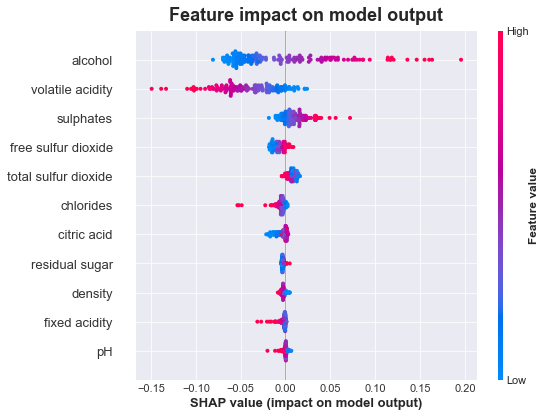

In [49]:
# Summarize the Shapley values in a plot
plt.title('Feature impact on model output')
shap.summary_plot(shap_values[0][:,:-2], X_test_frame[X_test_frame['red']==1][:400].iloc[:,:-2][:400])
plt.show()

**Let's look at some relationships from the plot. Three features with the highest contribution are alcohol (ABV), volatile acidity (acetic acid), and free sulfur dioxide. Volatile acidity is represented by predominantly red dots (indicating high feature values) on the left-side where there are negative SHAP values. This means that a higher amount of acetic acid in red wine is associated with less favorable (low quality) wine. The other major contributors--alcohol (ABV) and free sulfur dioxide amounts--have the the opposite relationship where their higher levels are associated with better quality red wines.**

In [56]:
# Plot the SHAP values for one red wine sample
INSTANCE_NUM = 99

shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][INSTANCE_NUM,:-2], X_test_frame[X_test_frame['red']==1].iloc[INSTANCE_NUM,:-2])
plt.show()

In [51]:
# Plot the SHAP values for multiple red wine samples

INSTANCE_NUM = list(np.arange(100))

shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][INSTANCE_NUM,:-2], X_test_frame[X_test_frame['red']==1].iloc[INSTANCE_NUM,:-2])
plt.show()

### White Wine
Next, we'll look at what makes a good white wine. Is it really distinct from the qualities of a good bottle of red wine?

In [52]:
# Extract Shapley values from the explainer
# Select test data representing white wine category
shap_values = explainer.shap_values(X_test_frame[X_test_frame['white']==1][:400])

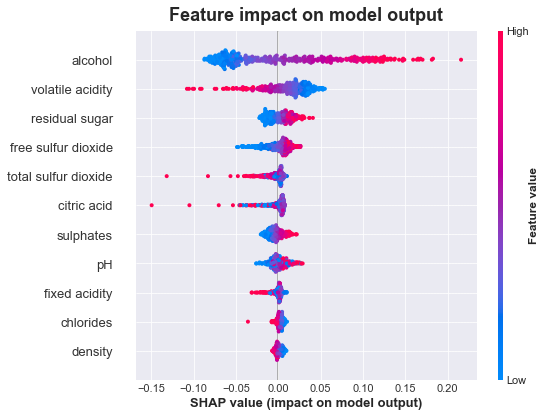

In [53]:
# Summarize the Shapley values in a plot
plt.title('Feature impact on model output')
shap.summary_plot(shap_values[0][:,:-2], X_test_frame[X_test_frame['white']==1][:400].iloc[:,:-2][:400])
plt.show()

In predicting the quality of white wine, features with the highest contribution include alcohol (ABV), volatile acidity, free sulfur dioxide, and residual sugar. Higher volatile acidity is considered less favorable in white wine (as well as red wine). Meanwhile, higher amounts of alcohol (ABV), free sulfur dioxide, and residual sugar are preferred qualities in white wine as they are associated with better quality (higher-scoring) wines

In [54]:
# Plot the SHAP values for one white wine sample
INSTANCE_NUM = 42

shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][INSTANCE_NUM,:-2], X_test_frame[X_test_frame['white']==1].iloc[INSTANCE_NUM,:-2])
plt.show()

In [55]:
# Plot the SHAP values for multiple white wine samples

INSTANCE_NUM = list(np.arange(100))

shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][INSTANCE_NUM,:-2], X_test_frame[X_test_frame['white']==1].iloc[INSTANCE_NUM,:-2])
plt.show()

**In general, experts tend to identify wines with lower volatile acidity (acetic acid), and higher amounts of alcohol (ABV) and free sulfur dioxide as higher-quality wines. In white wine, higher residual sugar level is also favorable. These are the physicochemical measurements winemakers should keep their eye on to really impress the experts (and win the market!). Cheers! 🍷**